<a href="https://colab.research.google.com/github/howardya/ml-finance/blob/main/volatility/volatility_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

US Total Equity Market Vol (RMSE)

| Method | Weekly (2M) |
| --- | --- |
| 2M Vol | 0.0286387|
| 1M Vol | 0.0277460|
|4M Vol|0.0296685|
| 2M Halflife | 0.0274711|
| 1M Halflife | 0.0272838|
|4M Halflife|0.0273250|
|4M NN-1 Unnormalized|0.0586515|
|4M NN-256-128-1 Unnormalized|0.0265297|
|4M NN-256-128-1 Unnormalized Relu|0.0272581|
|4M NN-1|0.0319316|
|4M NN-256-128-1|0.0236697|
|4M NN-256-128-1 Relu|0.0234757|
|4M NN-256-D20-128-D20-1 Relu|0.0239659|


# Volatility Forecast

In [57]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Print out packages' version

In [3]:
loaded_packages = ['pd', 'pdr', 'np','tf']
for pkg in loaded_packages:
  exec(f'pkg_version = {pkg}.__version__') # get the package's version to be printed out, stored as pkg_version
  print(f'{pkg} version: {pkg_version}')

pd version: 1.1.5
pdr version: 0.9.0
np version: 1.19.5
tf version: 2.6.0


# Get Data

In [4]:
start_date = '2000-01-01'
end_date = '2021-10-01'
fred_tickers = [
  'WILL5000IND', # https://fred.stlouisfed.org/series/WILL5000IND Wilshire 5000 Total Market Index
  # 'NASDAQ100', # https://fred.stlouisfed.org/series/NASDAQ100 
  # 'SP500', # https://fred.stlouisfed.org/series/SP500
  # 'DGS10', # https://fred.stlouisfed.org/series/DGS10
  # 'DGS2', # https://fred.stlouisfed.org/series/DGS2
]
data = web.DataReader(fred_tickers, 'fred', start = start_date, end=end_date)

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5675 entries, 2000-01-03 to 2021-10-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   WILL5000IND  5474 non-null   float64
dtypes: float64(1)
memory usage: 88.7 KB
None


In [6]:
weekly_data = data.resample('W').last() # get the last weekly trading price, dates are on Sunday
weekly_data_returns = np.log1p(weekly_data.pct_change().add_suffix('_Ret')).dropna() # calculate weekly log returns

Metric

In [30]:
def calculate_error_rmse(pd1, pd2):
  return np.sqrt( ((pd1.iloc[:,0].values-pd2.iloc[:,0].values)**2).mean())


## Calculate Realized Volatility

Defined as $\sum_i x_i^2$ where $x_i$s are the forward weekly returns

In [8]:
# Calculate the forward realize volatility
forward_window = 8 # in weeks

realized_volatility = np.log1p(
    weekly_data.pct_change().add_suffix('_Ret')
  ).dropna().pow(2).rolling(window = forward_window, min_periods=forward_window).mean().shift(-forward_window).pow(0.5).add_suffix('_Realized_Vol').dropna()

training_volatility = realized_volatility[:'2019']
training_dates = training_volatility.index

validation_volatility = realized_volatility['2020':]
validation_dates = validation_volatility.index



## Method 1: Rolling Vol

In [31]:
simple_vol = weekly_data_returns.pow(2).rolling(window=forward_window).mean().pow(0.5).loc[validation_dates]
print(f'2M Rolling: {calculate_error_rmse(simple_vol, validation_volatility)}')

simple_vol = weekly_data_returns.pow(2).rolling(window=int(0.5*forward_window) ).mean().pow(0.5).loc[validation_dates]
print(f'1M Rolling: {calculate_error_rmse(simple_vol, validation_volatility)}')

simple_vol = weekly_data_returns.pow(2).rolling(window=2*forward_window).mean().pow(0.5).loc[validation_dates]
print(f'4M Rolling: {calculate_error_rmse(simple_vol, validation_volatility)}')

2M Rolling: 0.028638700230523072
1M Rolling: 0.027745986066158797
4M Rolling: 0.02966853807756445


## Method 2: Halflife

In [32]:
predicted_vol = weekly_data_returns.pow(2).ewm(halflife=forward_window).mean().pow(0.5).loc[validation_dates]
print(f'2M Halflife: {calculate_error_rmse(predicted_vol, validation_volatility)}')

predicted_vol = weekly_data_returns.pow(2).ewm(halflife=int(0.5*forward_window) ).mean().pow(0.5).loc[validation_dates]
print(f'1M Halflife: {calculate_error_rmse(predicted_vol, validation_volatility)}')

predicted_vol = weekly_data_returns.pow(2).ewm(halflife=2*forward_window).mean().pow(0.5).loc[validation_dates]
print(f'4M Halflife: {calculate_error_rmse(predicted_vol, validation_volatility)}')

2M Halflife: 0.027471132223528552
1M Halflife: 0.027283839126274273
4M Halflife: 0.027324973671621823


Dataset Preparation for Tensorflow

In [11]:
# def window_dataset_returns(series, window_size, batch_size=32,
#                    shuffle_buffer=1000):
#     dataset = tf.data.Dataset.from_tensor_slices(series)
#     dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#     dataset = dataset.shuffle(shuffle_buffer)
#     dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#     dataset = dataset.batch(batch_size).prefetch(1)
#     return dataset

def window_dataset_x(returns_series, dates, window_size, batch_size=1,shuffle_buffer=1000):
  returns_data = returns_series.loc[dates]
  dataset_x = tf.data.Dataset.from_tensor_slices(returns_data)
  dataset_x = dataset_x.window(window_size, shift=1, drop_remainder=True)
  dataset_x = dataset_x.flat_map(lambda window: window.batch(window_size))
  dataset = dataset_x.batch(batch_size).prefetch(1)
  return dataset

def window_dataset_y(target_volatility, window_size, batch_size=1,shuffle_buffer=1000):
  dataset_y = tf.data.Dataset.from_tensor_slices(target_volatility[window_size:])
  dataset = dataset_y.batch(batch_size).prefetch(1)
  return dataset

def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


## Method 3: Linear Regression (Without Normalization)

In [12]:
window_size = forward_window
batch_size = 32
shuffle_buffer=1000

train_x = rolling(weekly_data_returns.WILL5000IND_Ret[training_dates].values, window_size)
train_y = training_volatility.WILL5000IND_Ret_Realized_Vol.values[window_size-1:][:,None]
train_data = np.hstack((train_x,train_y))

validation_x = rolling(weekly_data_returns[weekly_data_returns.index <= validation_dates[-1]].WILL5000IND_Ret.values, window_size)[-len(validation_dates):]
validation_y = validation_volatility.WILL5000IND_Ret_Realized_Vol.values[:,None]
validation_data = np.hstack((validation_x,validation_y))


train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(shuffle_buffer)
train_dataset = train_dataset.map(lambda window: (window[:-1], window[-1]))
train_dataset = train_dataset.batch(batch_size).prefetch(1)

validation_dataset = tf.data.Dataset.from_tensor_slices(validation_data)
validation_dataset = validation_dataset.map(lambda window: (window[:-1], window[-1]))
validation_dataset = validation_dataset.batch(batch_size).prefetch(1)


In [37]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1,input_shape=[window_size])
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0015 - m

In [39]:
prediction = model.predict(validation_x)
calculate_error_rmse(pd.DataFrame(prediction), validation_volatility)

0.05865153412409621

In [40]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, input_shape=[window_size]),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 6.6522e-04 - mse: 6.6522e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 6.3620e-04 - mse: 6.3620e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 6.0685e-04 - mse: 6.0685e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 5.7936e-04 - mse: 5.7936e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 5.5374e-04 - mse: 5.5374e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 5.2990e-04 - mse: 5.2990e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 5.0787e-04 - mse: 5.0787e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/100
33/33 [========

In [41]:
prediction = model.predict(validation_x)
calculate_error_rmse(pd.DataFrame(prediction), validation_volatility)

0.026529689148563504

In [42]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
model.fit(train_dataset, epochs=100, validation_data=validation_dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 5.1172e-04 - mse: 5.1172e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 5.0430e-04 - mse: 5.0430e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 4.9638e-04 - mse: 4.9638e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 4.8862e-04 - mse: 4.8862e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 4.8103e-04 - mse: 4.8103e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 4.7365e-04 - mse: 4.7365e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 4.6640e-04 - mse: 4.6640e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 8/100
33/33 [========

In [43]:
prediction = model.predict(validation_x)
calculate_error_rmse(pd.DataFrame(prediction), validation_volatility)

0.027258098296350227

## Linear Regression (Normalize)

In [47]:
window_size = forward_window
batch_size = 32
shuffle_buffer=1000

train_x = rolling(weekly_data_returns.WILL5000IND_Ret[training_dates].values, window_size)
scaler_x = train_x.std()
train_x = train_x / scaler_x
train_y = training_volatility.WILL5000IND_Ret_Realized_Vol.values[window_size-1:][:,None]
scaler_y = train_y.std()
train_y = train_y / scaler_y
train_data = np.hstack((train_x,train_y))

validation_x = rolling(weekly_data_returns[weekly_data_returns.index <= validation_dates[-1]].WILL5000IND_Ret.values, window_size)[-len(validation_dates):]
validation_y = validation_volatility.WILL5000IND_Ret_Realized_Vol.values[:,None]
validation_x = validation_x / scaler_x
validation_y = validation_y / scaler_y
validation_data = np.hstack((validation_x,validation_y))


train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(shuffle_buffer)
train_dataset = train_dataset.map(lambda window: (window[:-1], window[-1]))
train_dataset = train_dataset.batch(batch_size).prefetch(1)

validation_dataset = tf.data.Dataset.from_tensor_slices(validation_data)
validation_dataset = validation_dataset.map(lambda window: (window[:-1], window[-1]))
validation_dataset = validation_dataset.batch(batch_size).prefetch(1)


In [61]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1,input_shape=[window_size])
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [49]:
prediction = model.predict(validation_x)
calculate_error_rmse(pd.DataFrame(prediction).mul(scaler_y), validation_volatility)

0.03193162502759505

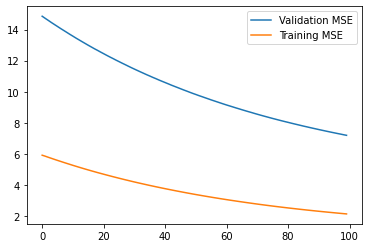

In [72]:
plt.plot(history.history['val_mse'],label='Validation MSE')
plt.plot(history.history['mse'],label='Training MSE')
plt.legend()

In [73]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256,input_shape=[window_size]),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=0)

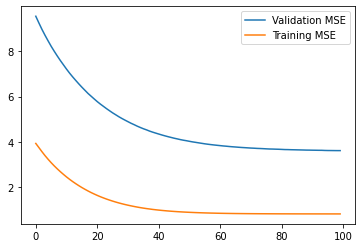

In [74]:
plt.plot(history.history['val_mse'],label='Validation MSE')
plt.plot(history.history['mse'],label='Training MSE')
plt.legend()

In [75]:
prediction = model.predict(validation_x)
calculate_error_rmse(pd.DataFrame(prediction).mul(scaler_y), validation_volatility)

0.023669748462590318

In [76]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256,input_shape=[window_size],activation="relu"),
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=0)

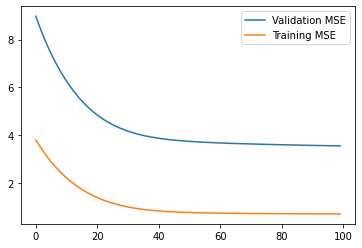

In [77]:
plt.plot(history.history['val_mse'],label='Validation MSE')
plt.plot(history.history['mse'],label='Training MSE')
plt.legend()

In [78]:
prediction = model.predict(validation_x)
calculate_error_rmse(pd.DataFrame(prediction).mul(scaler_y), validation_volatility)

0.023475703402842094

In [82]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=0)

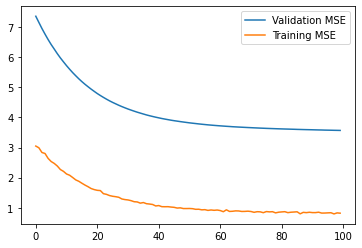

In [83]:
plt.plot(history.history['val_mse'],label='Validation MSE')
plt.plot(history.history['mse'],label='Training MSE')
plt.legend()

In [84]:
prediction = model.predict(validation_x)
calculate_error_rmse(pd.DataFrame(prediction).mul(scaler_y), validation_volatility)

0.02351698303418633

## Add in Squared-Feature

In [85]:
window_size = forward_window
batch_size = 32
shuffle_buffer=1000

train_x = rolling(weekly_data_returns.WILL5000IND_Ret[training_dates].values, window_size)
scaler_x = train_x.std()
train_x = train_x / scaler_x
scaler_x2 = (train_x**2).std()
train_x2 = (train_x**2) / scaler_x2
train_y = training_volatility.WILL5000IND_Ret_Realized_Vol.values[window_size-1:][:,None]
scaler_y = train_y.std()
train_y = train_y / scaler_y

train_data = np.hstack((train_x,train_x2,train_y))

validation_x = rolling(weekly_data_returns[weekly_data_returns.index <= validation_dates[-1]].WILL5000IND_Ret.values, window_size)[-len(validation_dates):]
validation_y = validation_volatility.WILL5000IND_Ret_Realized_Vol.values[:,None]
validation_x = validation_x / scaler_x
validation_x2 = (validation_x**2) / scaler_x2
validation_y = validation_y / scaler_y
validation_data = np.hstack((validation_x,validation_x2,validation_y))


train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(shuffle_buffer)
train_dataset = train_dataset.map(lambda window: (window[:-1], window[-1]))
train_dataset = train_dataset.batch(batch_size).prefetch(1)

validation_dataset = tf.data.Dataset.from_tensor_slices(validation_data)
validation_dataset = validation_dataset.map(lambda window: (window[:-1], window[-1]))
validation_dataset = validation_dataset.batch(batch_size).prefetch(1)


In [95]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(256,activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_dataset, epochs=500, validation_data=validation_dataset, verbose=1)

Epoch 1/500
33/33 [==============================] - 0s 5ms/step - loss: 3.8898 - mse: 3.8898 - val_loss: 8.9094 - val_mse: 8.9094
Epoch 2/500
33/33 [==============================] - 0s 3ms/step - loss: 3.5167 - mse: 3.5167 - val_loss: 8.3123 - val_mse: 8.3123
Epoch 3/500
33/33 [==============================] - 0s 3ms/step - loss: 3.3497 - mse: 3.3497 - val_loss: 7.7378 - val_mse: 7.7378
Epoch 4/500
33/33 [==============================] - 0s 3ms/step - loss: 3.0663 - mse: 3.0663 - val_loss: 7.2697 - val_mse: 7.2697
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 2.8674 - mse: 2.8674 - val_loss: 6.8824 - val_mse: 6.8824
Epoch 6/500
33/33 [==============================] - 0s 3ms/step - loss: 2.7246 - mse: 2.7246 - val_loss: 6.5365 - val_mse: 6.5365
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 2.5637 - mse: 2.5637 - val_loss: 6.2510 - val_mse: 6.2510
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 2.3874 - m

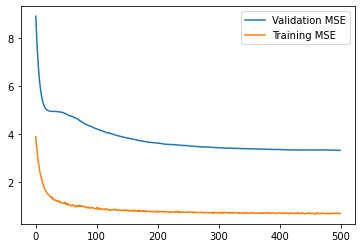

In [96]:
plt.plot(history.history['val_mse'],label='Validation MSE')
plt.plot(history.history['mse'],label='Training MSE')
plt.legend()

In [99]:
prediction = model.predict(np.hstack((validation_x,validation_x2)))
calculate_error_rmse(pd.DataFrame(prediction).mul(scaler_y), validation_volatility)

0.022707300434842134